# fMRI-01 Solutions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.5)
%matplotlib inline

Today's demonstration will introduce programmatic implementations of the hemodynamic response function (HRF). We will cover the canonical double gamma model, as well as other variants introduced in the literature.

## Double Gamma HRF
Much like the action potential, the canonical hemodynamic response has two distinct phases: a initial rising phase and a subsequent prolonged undershoot. In general, the rising phase peaks around 6s and the trough of the undershoot occurs around 16s. 

Traditionally, the shape of the HRF is modeled by the superposition of two **[gamma distributions](https://en.wikipedia.org/wiki/Gamma_distribution)**. The gamma distribution can be defined according to several different parameterizations. Here, we will define gamma according to its mode and variance. The mode defines the center of the probability mass of the distribution, whereas the variance describes the dispersion around the mean. 

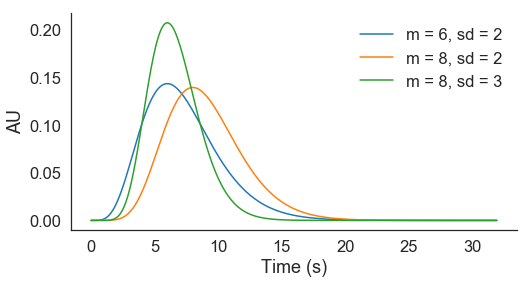

In [2]:
from fmritools.hrf import gamma_mode_pdf

## Define times.
times = np.arange(0, 32, 0.1)

## Evaluate PDF.
pdf_1 = gamma_mode_pdf(times, 6, 3)
pdf_2 = gamma_mode_pdf(times, 8, 3)
pdf_3 = gamma_mode_pdf(times, 6, 2)

## Plotting.
fig, ax = plt.subplots(1,1,figsize=(8,4))
ax.plot(times, pdf_1, label='m = 6, sd = 2')
ax.plot(times, pdf_2, label='m = 8, sd = 2')
ax.plot(times, pdf_3, label='m = 8, sd = 3')
ax.set(xlabel='Time (s)', ylabel='AU')
ax.legend(loc=1, frameon=False)
sns.despine()

An important point is the difference in shape between the gamma and normal distributions. Whereas the normal distribution has symmetric shape (i.e. the distributions of its left and right tails are the same), the gamma distribution is right-tailed (i.e. has greater probability mass for larger values). This asymmetry nicely captures what is typically observed of the HRF.

To model the HRF, we will need two gamma distributions: one to capture the rising phase and a second to capture the undershoot. To give it its characteristic shape, we will (1) assume the second is smaller in amplitude than the first, and (2) subtract the second from the first.

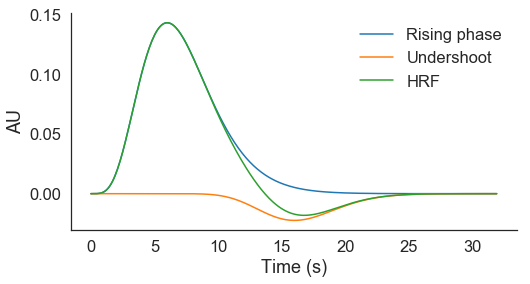

In [3]:
from fmritools.hrf import spm_hrf, inv_logit_hrf, double_gaussian_hrf

## Define times.
times = np.arange(0, 32, 0.1)

## Evaluate PDF.
rising = gamma_mode_pdf(times,  6, 3)
undershoot = -gamma_mode_pdf(times, 16, 3) / 6
hrf = rising + undershoot

## Plotting.
fig, ax = plt.subplots(1,1,figsize=(8,4))
ax.plot(times, rising, label='Rising phase')
ax.plot(times, undershoot, label='Undershoot')
ax.plot(times, hrf, label='HRF')
ax.set(xlabel='Time (s)', ylabel='AU')
ax.legend(loc=1, frameon=False)
sns.despine()

Now we have an HRF-like waveform. Through much empirical study, neuroimagers eventually arrived at a set of parameters that best described the HRF across a range of conditions. In this class, we will call this the canonical HRF or the **SPM HRF.** 

The SPM HRF has been conveniently programmed for you already. Importantly, the `spm_hrf` function requires the **repetition time (TR)** as an input. The TR is the sampling frequency of an fMRI experiment, or how often we acquire one complete image of the brain. The TR defines the smoothness of the idealized HRF.

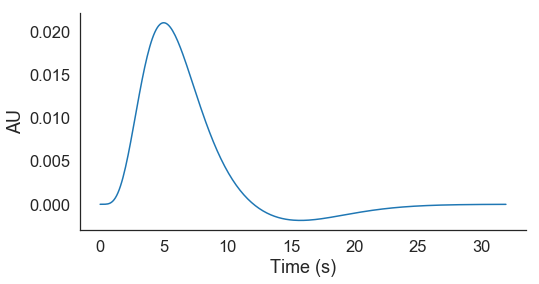

In [4]:
from fmritools.hrf import spm_hrf

## Define HRF.
tr = 0.1
hrf = spm_hrf(tr)
times = np.arange(0, 32, tr)

## Plotting.
fig, ax = plt.subplots(1,1,figsize=(8,4))
ax.plot(times, hrf)
ax.set(xlabel='Time (s)', ylabel='AU')
sns.despine()

## Alternate HRFs
The (double gamma) SPM HRF is the default HRF in neuroimaging studies; it is the function employed in all of the major fMRI software packages. This is great for reproducibility and reducing researcher degrees of freedom, but it should be noted that this is a major assumption of most fMRI studies and much ink has been spilled over when this assumption is valid and how to improve HRF modeling in a principled manner. (This will be discussed more in the coming weeks.)

For today, we can explore the shape of a few other HRFs that have been discussed in the literature. This includes double-normal HRF and the inverse-logistic HRF.

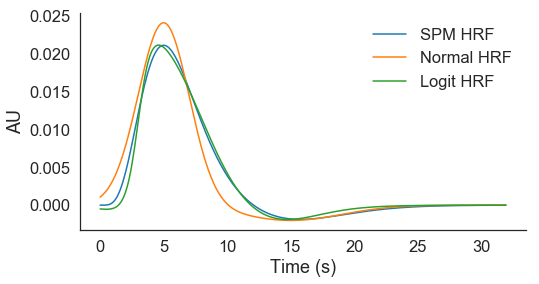

In [8]:
from fmritools.hrf import double_gaussian_hrf, inv_logit_hrf, double_gamma_hrf

## Plotting.
fig, ax = plt.subplots(1,1,figsize=(8,4))
ax.plot(times, spm_hrf(0.1), label='SPM HRF')
ax.plot(times, double_gaussian_hrf(0.1), label='Normal HRF')
ax.plot(times, inv_logit_hrf(0.1), label='Logit HRF')
ax.legend(loc=1, frameon=False)
ax.set(xlabel='Time (s)', ylabel='AU')
sns.despine()

One important point to add is that it is exceedingly rare for fMRI software packages to model the initial dip of the HRF. This is in part due to the (1) controversial status of the initial dip, (2) historical artifact of slow scanning, and (3) pure inertia.